In [642]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report
from statsmodels.stats.outliers_influence import variance_inflation_factor
from varclushi import VarClusHi
from imblearn.over_sampling import SMOTE,SMOTENC, RandomOverSampler
import joblib
sm = SMOTE(random_state=32)
smc = SMOTENC(random_state=52,categorical_features=[14,15,16])
rs = RandomOverSampler(random_state=37)
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 50000)
pd.set_option('display.max_columns', 500)
pd.set_option('float_format', '{:f}'.format)
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [2]:
df = pd.read_excel('../Data- acquisition scorecard.xlsx')

In [3]:
df.rename(columns={'ENQ_1':'days_last_enq','ENQ_2':'days_hl_last_enq','ENQ_3':'#_enq_3mnths','ENQ_4':'#_hle_enq_3mnths','ENQ_5':'#_enq_12mnths','ENQ_6':'#_hle_enq_12mnths','ENQ_7':'Tot_enq','ENQ_8':'Tot_hle_enq','ACCOUNT_9':'#_defaults_3mnths','ACCOUNT_10':'#_defaults_12mnths','ACCOUNT_11':'days_last_acc_open','ACCOUNT_12':'Tot_accounts','ACCOUNT_13':'Tot_hle_accounts','ACCOUNT_14':'Tot_unsecured_loans','ACCOUNT_15':'Tot_live_loans','ACCOUNT_16':'Tot_live_homeloans','ACCOUNT_17':'Tot_live_unsecuredloans','ACCOUNT_18':'Tot_amt_outstanding','ACCOUNT_19':'Tot_secured_outstanding_amt','ACCOUNT_20':'Tot_unsecured_outstanding_amt','ACCOUNT_21':'Avg_days_in_debt'},inplace=True)

In [4]:
df.head()

,ID,Age,Customer_type,Gross_income,Net_income,SEX,Type_of_industry,Marital_Status,Months_in_city,Months_in_current_job,Org_Type,Bank_balance,Debt_ratio,Target,days_last_enq,days_hl_last_enq,#_enq_3mnths,#_hle_enq_3mnths,#_enq_12mnths,#_hle_enq_12mnths,Tot_enq,Tot_hle_enq,#_defaults_3mnths,#_defaults_12mnths,days_last_acc_open,Tot_accounts,Tot_hle_accounts,Tot_unsecured_loans,Tot_live_loans,Tot_live_homeloans,Tot_live_unsecuredloans,Tot_amt_outstanding,Tot_secured_outstanding_amt,Tot_unsecured_outstanding_amt,Avg_days_in_debt
0,1794,40.000,SALARIED,70891.000,62491.000,MALE,OTHERS,MARRIED,229.000,108,INDIVIDUAL,37806.000,0.190,0,324,0,0,0,1,0,14,0,0,0,1486,9,0,8,2,0,2,275606,0,275606,5311
1,3183,35.000,SALARIED,53617.000,53617.000,MALE,OTHERS,MARRIED,408.000,60,INDIVIDUAL,15499.000,0.420,0,616,1978,0,0,0,0,11,1,5,5,1912,8,0,6,1,0,0,4844,4824,20,5289
2,1841,46.000,SALARIED,20000.000,45912.000,MALE,OTHERS,MARRIED,552.000,204,INDIVIDUAL,15034.000,0.340,0,688,0,0,0,0,0,3,0,0,0,681,4,2,1,1,1,0,15695,15695,0,5153
3,1115,49.000,SALARIED,40000.000,77440.000,FEMALE,OTHERS,MARRIED,0.000,0,INDIVIDUAL,27349.000,0.080,0,52,52,2,2,3,2,3,2,0,0,5143,1,1,0,1,1,0,480051,480051,0,5143
4,3125,45.000,SELF EMPLOYED,36526.000,36526.000,MALE,OTHERS,MARRIED,540.000,22,INDIVIDUAL,28520.000,0.480,0,33,0,1,0,1,0,2,0,5,5,3310,2,0,0,1,0,0,2781,2781,0,5093


In [5]:
df_copy = df.copy()

### Data Pre Processing

In [6]:
len(df)

3980

In [7]:
df.ID.nunique()

3894

In [8]:
df.drop(df[df.duplicated()].index,inplace=True)

In [9]:
df.isnull().sum().sort_values(ascending=False).head(10)

Bank_balance           626
Type_of_industry         5
SEX                      4
Marital_Status           4
Months_in_city           4
Age                      1
ID                       0
Tot_unsecured_loans      0
#_defaults_12mnths       0
days_last_acc_open       0
dtype: int64

In [10]:
sal_bb = df.loc[df['Customer_type'] == 'SALARIED','Bank_balance'].mean()
se_bb = df.loc[df['Customer_type'] == 'SELF EMPLOYED','Bank_balance'].mean()
ne_bb = df.loc[df['Customer_type'] == 'NON EARNING','Bank_balance'].mean()

In [11]:
df['Bank_balance'] = np.where((df['Customer_type'] == 'SALARIED') & (df['Bank_balance'].isna()),sal_bb,np.where(((df['Customer_type'] == 'SELF EMPLOYED')&(df['Bank_balance'].isna())),se_bb,np.where(((df['Customer_type'] == 'NON EARNING') & (df['Bank_balance'].isna())),ne_bb,df['Bank_balance'])))

In [12]:
df.isnull().sum().sort_values(ascending=False).head(10)

Type_of_industry       5
SEX                    4
Marital_Status         4
Months_in_city         4
Age                    1
ID                     0
Tot_unsecured_loans    0
#_defaults_3mnths      0
#_defaults_12mnths     0
days_last_acc_open     0
dtype: int64

In [13]:
df.dropna(inplace=True)

----

In [ ]:
sns.pairplot(df,hue='Target')

In [620]:
print((df['#_enq_3mnths'] < df['#_hle_enq_3mnths']).sum())
print((df['#_enq_12mnths'] < df['#_hle_enq_12mnths']).sum())
print((df['#_enq_3mnths'] == df['#_hle_enq_3mnths']).sum())
print((df['#_enq_12mnths'] == df['#_hle_enq_12mnths']).sum())

0
0
2575
1473


In [621]:
pd.DataFrame(df.groupby('Customer_type')[['#_defaults_3mnths']].value_counts(normalize=True)).rename(columns={0:'Proportion of defaults'})

Proportion of defaults
Customer_type #_defaults_3mnths                        
NON EARNING   0                                0.826087
              1                                0.086957
              2                                0.043478
              6                                0.043478
SALARIED      0                                0.882422
              1                                0.052322
              6                                0.017637
              2                                0.017637
              3                                0.015873
              5                                0.007643
              4                                0.003527
              7                                0.002939
SELF EMPLOYED 0                                0.835550
              1                                0.074911
              2                                0.030585
              6                                0.024379
              3                                0.017287
              5                                0.007979
              4                                0.004876
              7                                0.004433

In [622]:
df.groupby(['Customer_type'])[['Gross_income','Net_income','Bank_balance','Debt_ratio']].mean()

,Gross_income,Net_income,Bank_balance,Debt_ratio
Customer_type,,,,
NON EARNING,25235.130435,30519.710000,11147.000000,0.693913
SALARIED,60032.507554,42543.267625,47105.382682,452.230735
SELF EMPLOYED,108471.387775,108076.720143,214506.598219,14995.725940


In [623]:
income_diff = df.loc[df[(df['Gross_income'] < df['Net_income'])].index,['ID','Customer_type','Gross_income','Net_income']]

In [624]:
income_diff.head()

,ID,Customer_type,Gross_income,Net_income
2,1841,SALARIED,20000.000000,45912.000000
3,1115,SALARIED,40000.000000,77440.000000
6,3602,SELF EMPLOYED,74455.580000,74455.583300
14,1277,SALARIED,31631.000000,41200.000000
15,2181,SELF EMPLOYED,66083.330000,66083.333300


In [625]:
income_diff.loc[income_diff['Customer_type'] == 'NON EARNING',:]

,ID,Customer_type,Gross_income,Net_income
333,1928,NON EARNING,30000.000000,30700.000000
409,2041,NON EARNING,63710.000000,69973.330000
1171,2745,NON EARNING,11173.000000,14252.000000
2310,2157,NON EARNING,20000.000000,40000.000000
2470,2031,NON EARNING,17000.000000,18000.000000
2493,1010,NON EARNING,1.000000,91234.000000
3023,2040,NON EARNING,26433.330000,26433.333300
3053,2081,NON EARNING,37566.000000,50359.000000


In [626]:
income_diff.groupby('Customer_type').size()

Customer_type
NON EARNING        8
SALARIED         798
SELF EMPLOYED    783
dtype: int64

<Axes: xlabel='Age', ylabel='Count'>

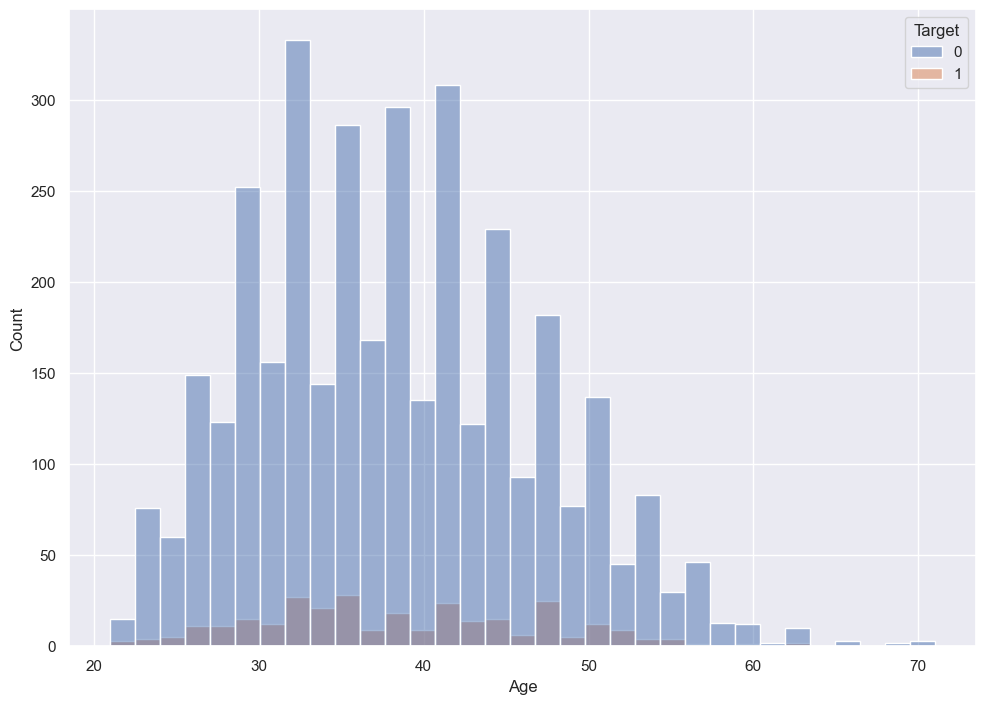

In [643]:
sns.histplot(x='Age',hue='Target',data=df)

<Axes: xlabel='Months_in_city', ylabel='Count'>

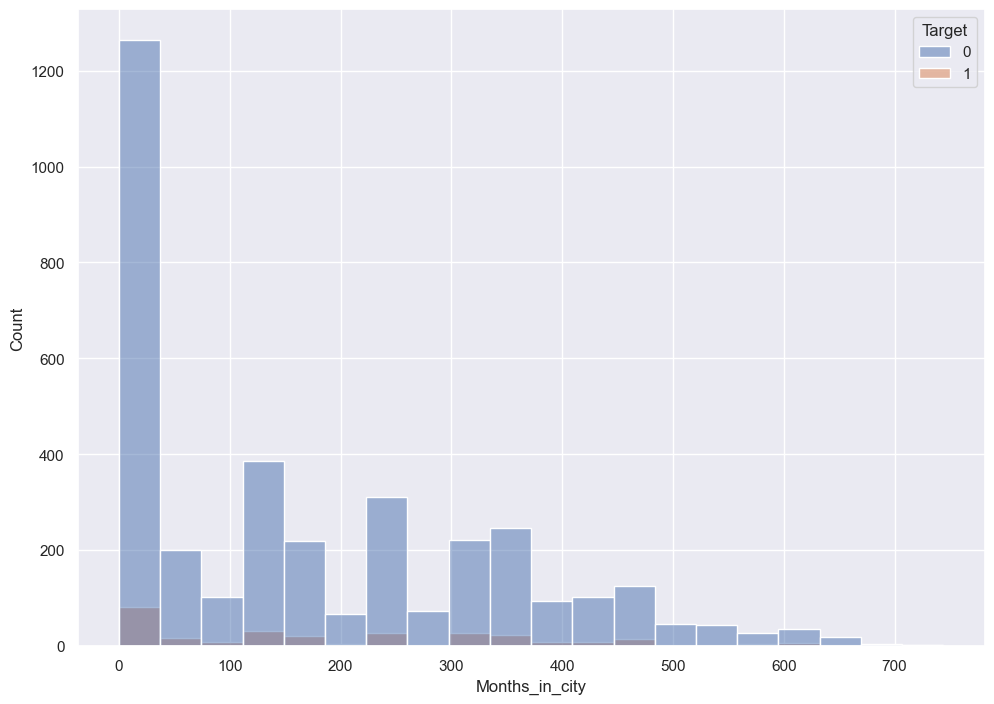

In [644]:
sns.histplot(x='Months_in_city',hue='Target',data=df)

In [ ]:
sns.histplot(x='Debt_ratio',hue='Target',data=df)

<Axes: xlabel='days_last_enq', ylabel='Count'>

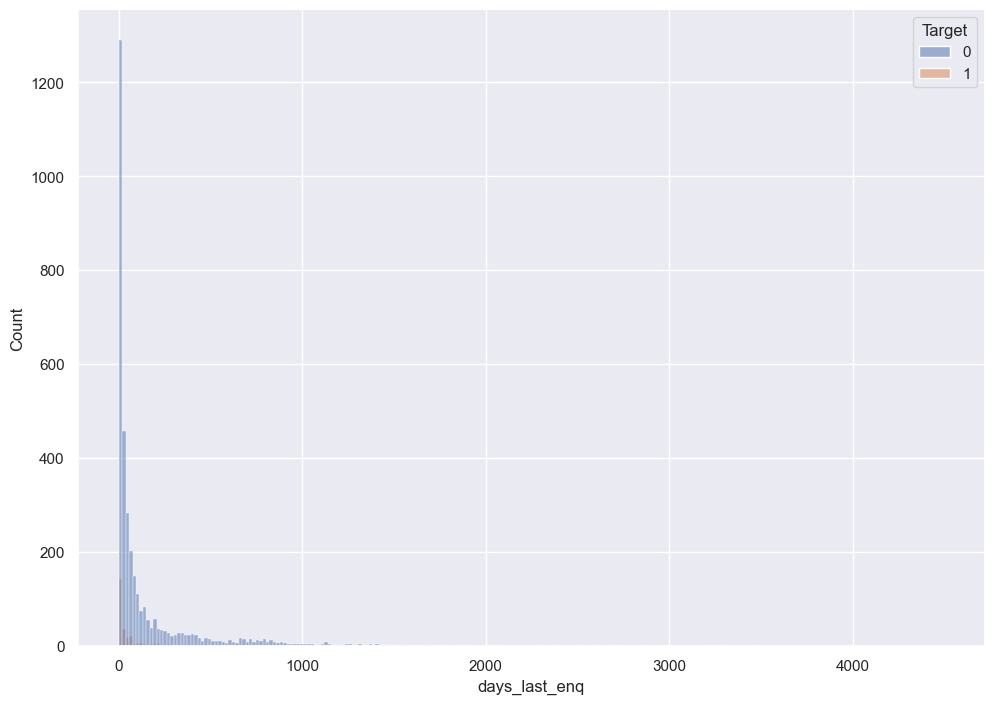

In [648]:
sns.histplot(x='days_last_enq',hue='Target',data=df)

<Axes: xlabel='days_hl_last_enq', ylabel='Count'>

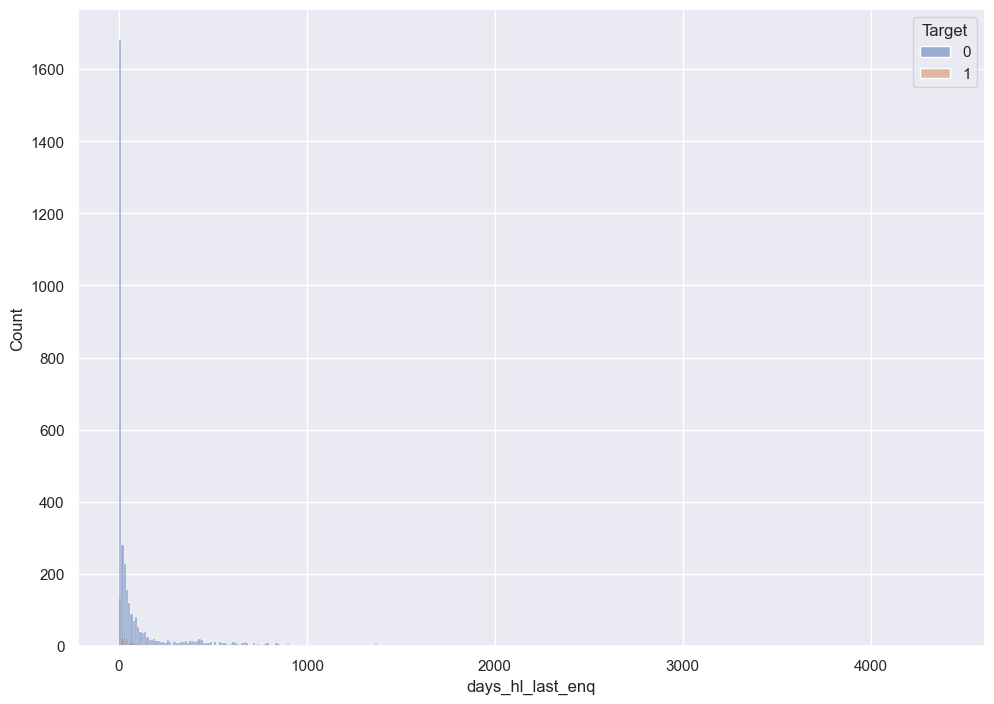

In [649]:
sns.histplot(x='days_hl_last_enq',hue='Target',data=df)

<Axes: xlabel='#_enq_3mnths', ylabel='Count'>

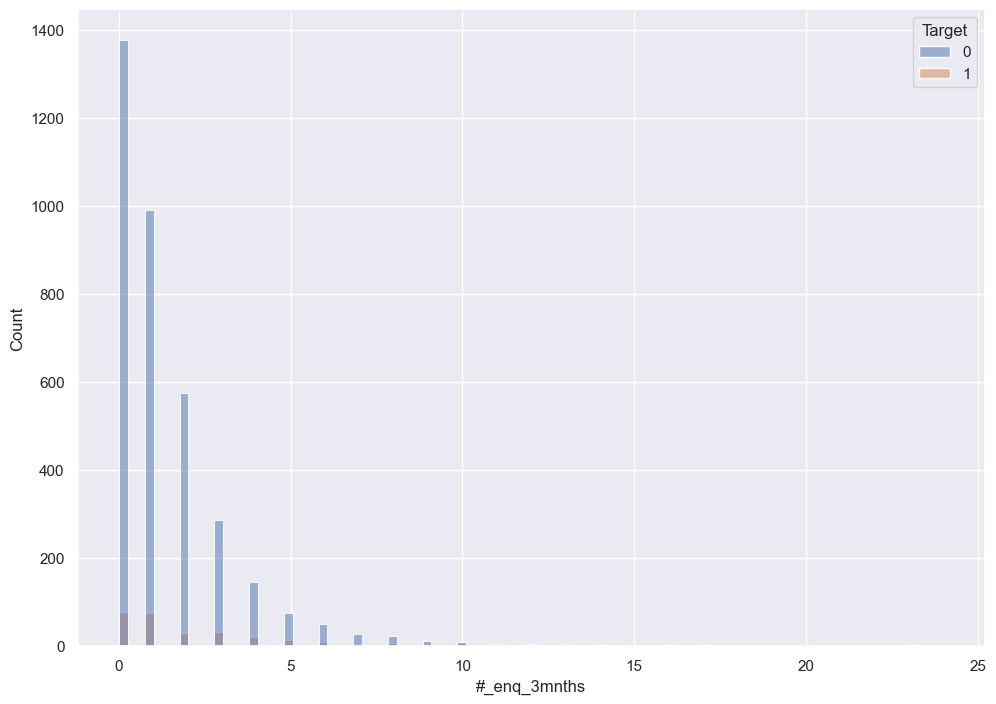

In [650]:
sns.histplot(x='#_enq_3mnths',hue='Target',data=df)

<Axes: xlabel='#_enq_12mnths', ylabel='Count'>

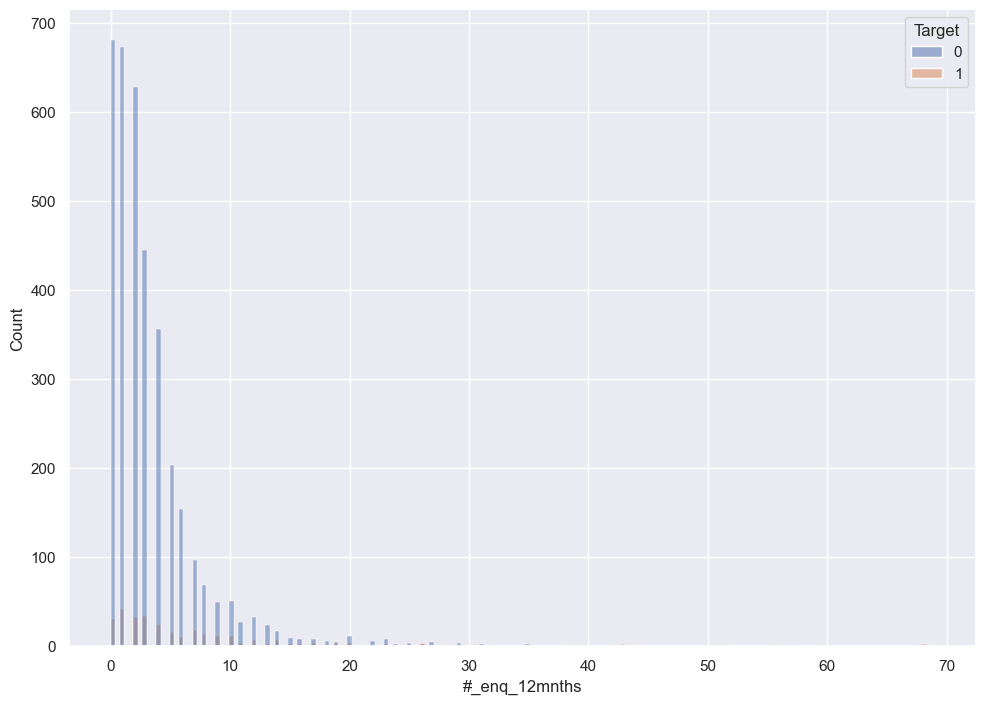

In [652]:
sns.histplot(x='#_enq_12mnths',hue='Target',data=df)

<Axes: xlabel='#_hle_enq_3mnths', ylabel='Count'>

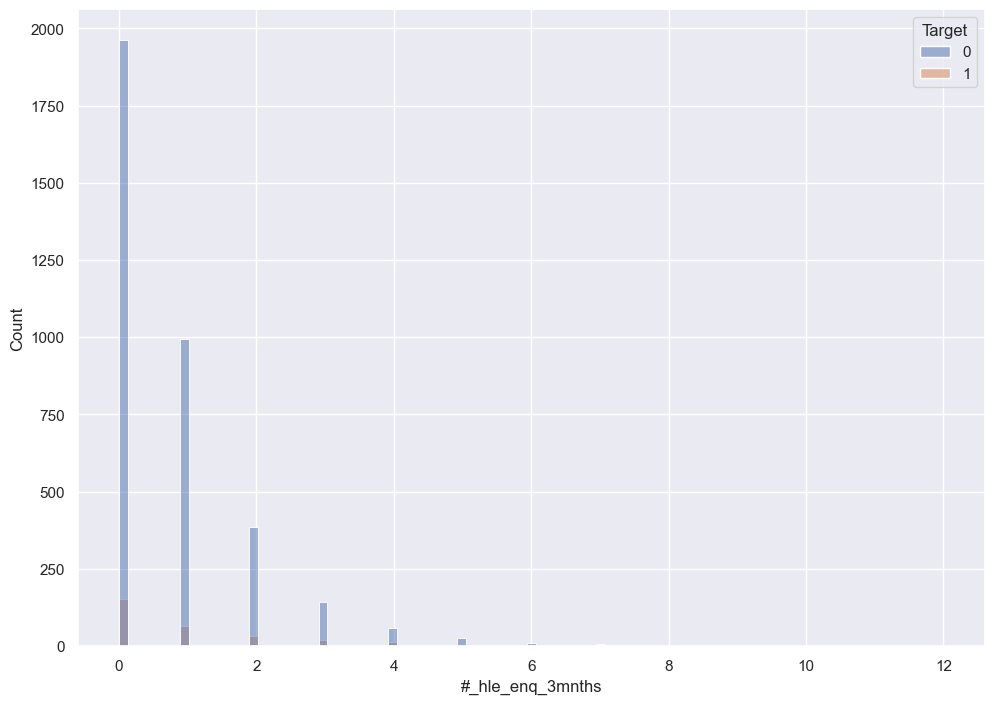

In [651]:
sns.histplot(x='#_hle_enq_3mnths',hue='Target',data=df)

<Axes: xlabel='#_hle_enq_12mnths', ylabel='Count'>

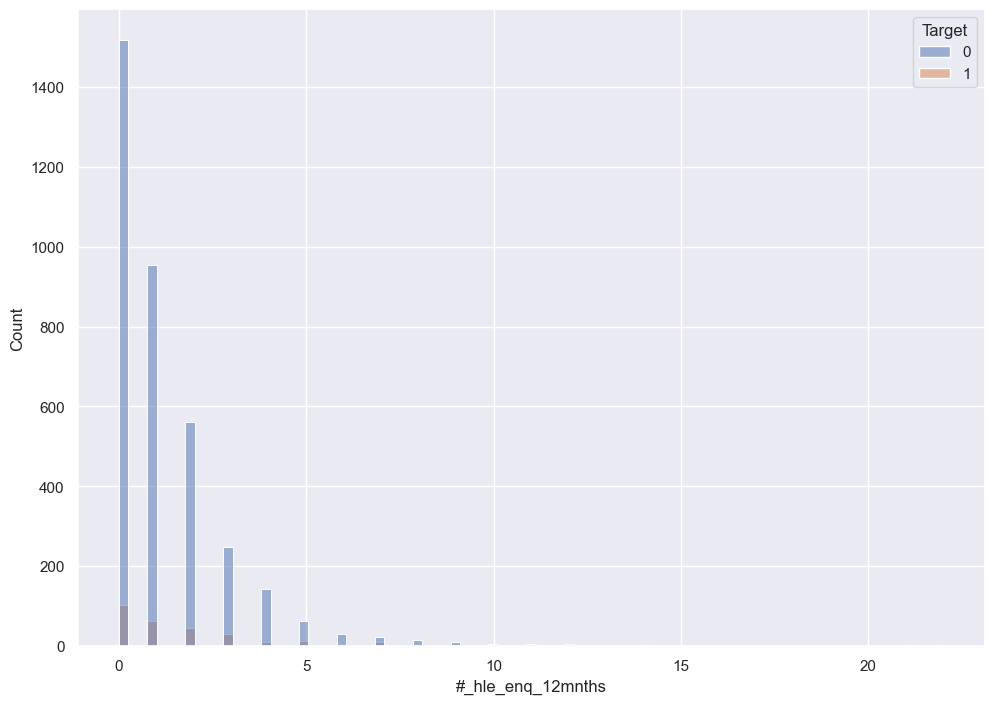

In [653]:
sns.histplot(x='#_hle_enq_12mnths',hue='Target',data=df)

<Axes: xlabel='Tot_accounts', ylabel='Count'>

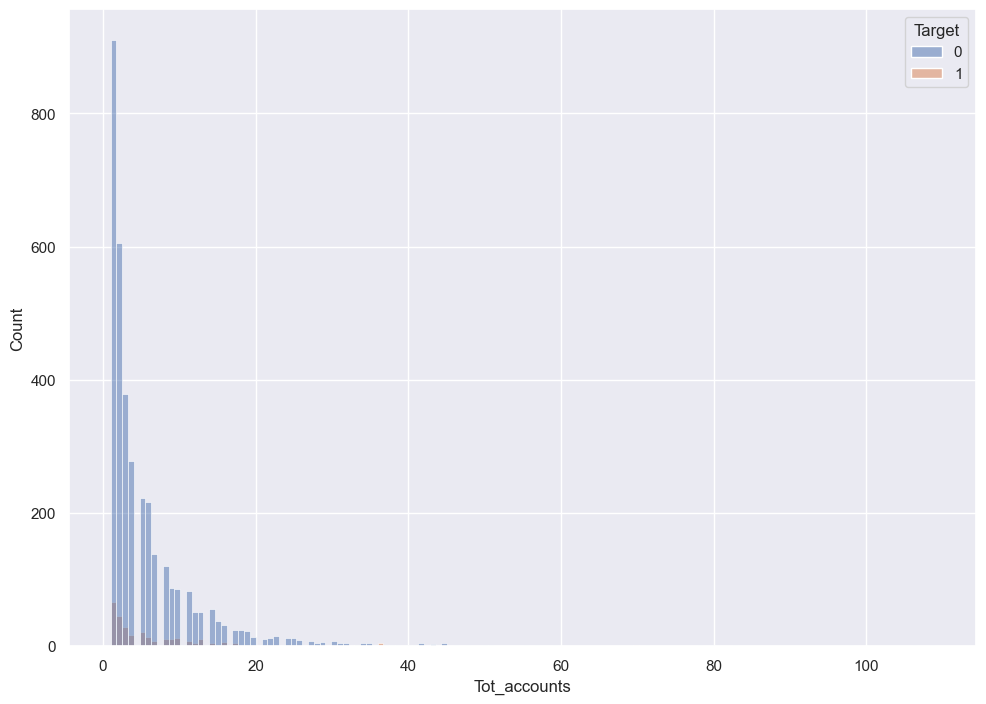

In [654]:
sns.histplot(x='Tot_accounts',hue='Target',data=df)

<Axes: xlabel='Tot_hle_accounts', ylabel='Count'>

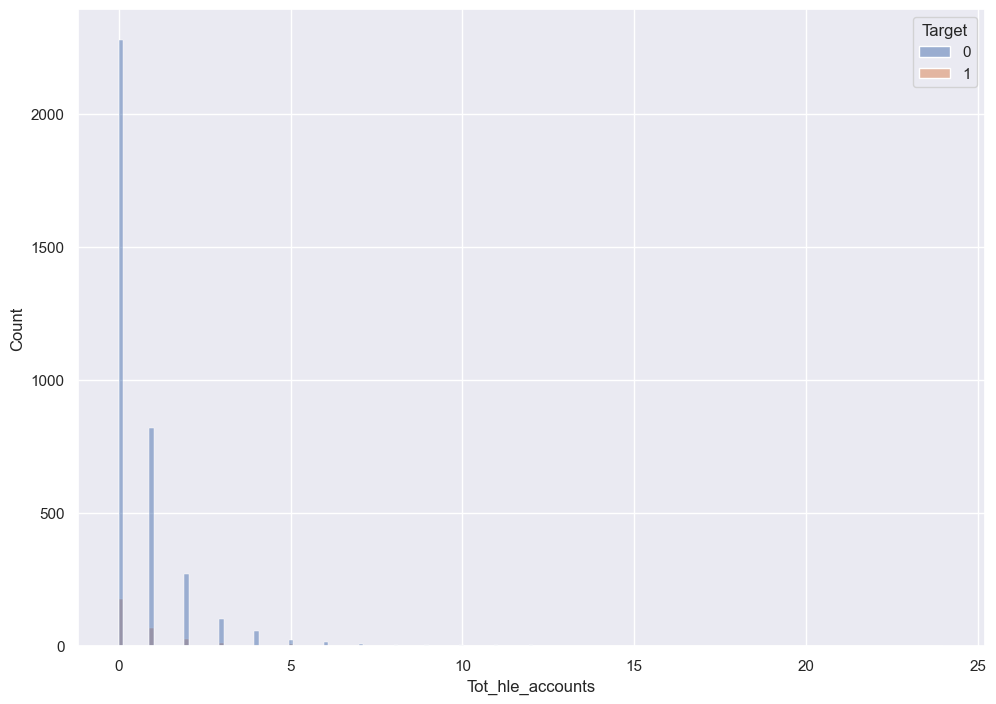

In [655]:
sns.histplot(x='Tot_hle_accounts',hue='Target',data=df)

<Axes: xlabel='Tot_unsecured_loans', ylabel='Count'>

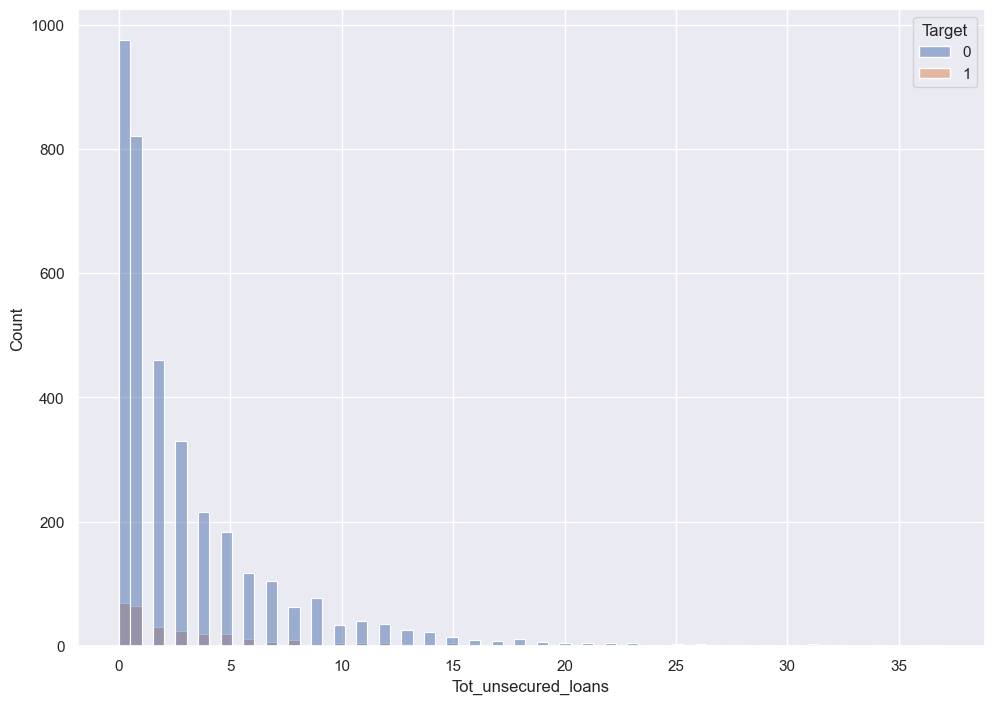

In [656]:
sns.histplot(x='Tot_unsecured_loans',hue='Target',data=df)

<Axes: xlabel='Tot_live_unsecuredloans', ylabel='Count'>

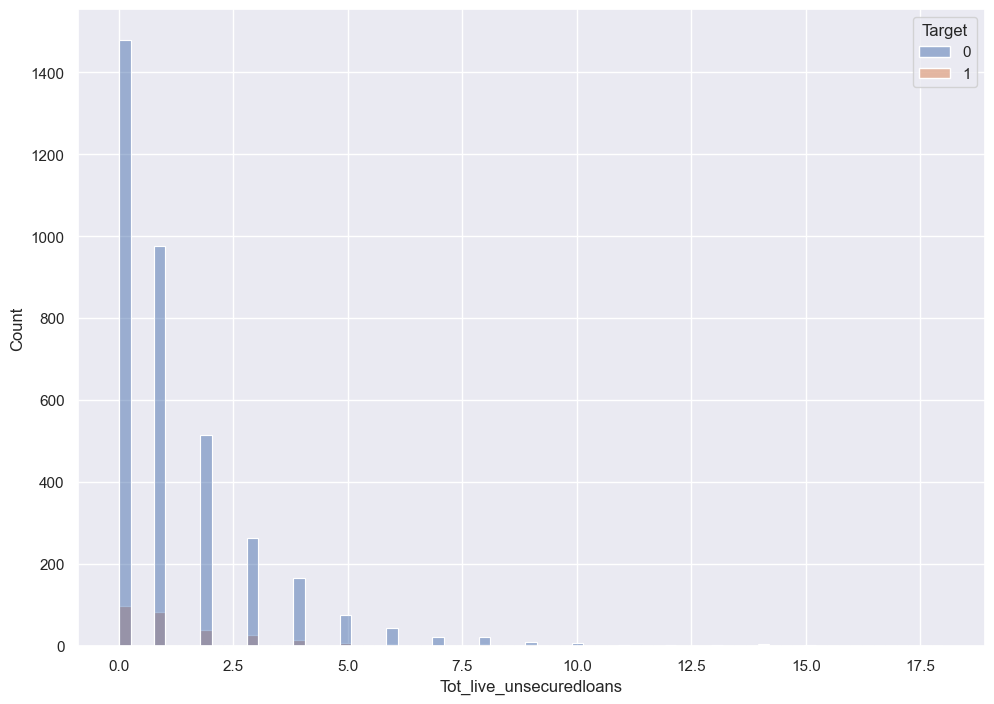

In [658]:
sns.histplot(x='Tot_live_unsecuredloans',hue='Target',data=df)

<Axes: xlabel='Tot_live_loans', ylabel='Count'>

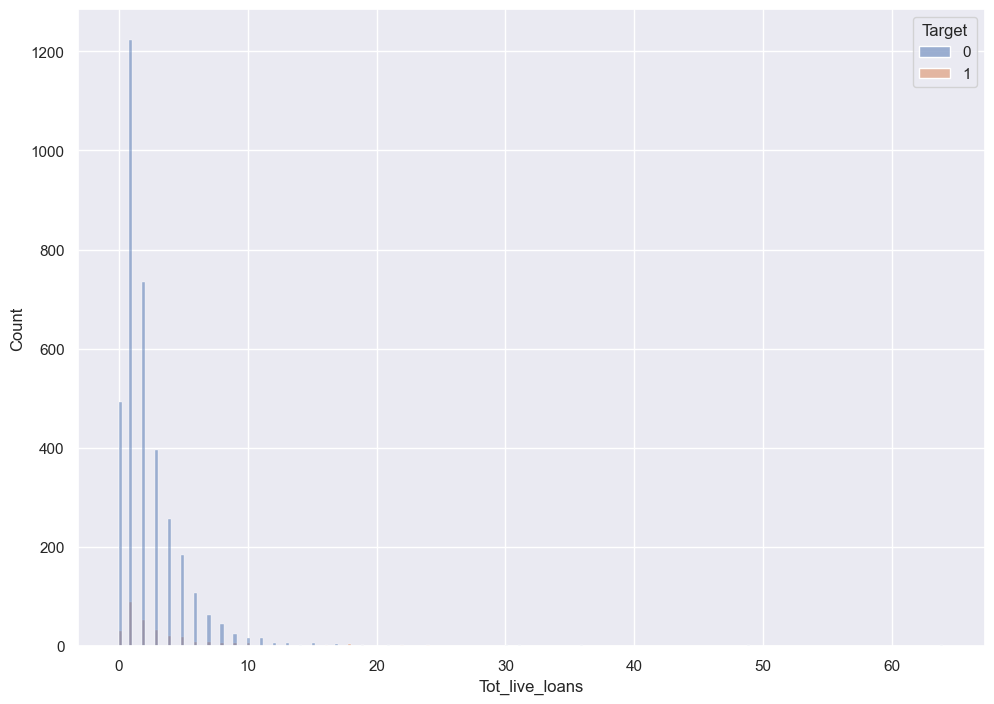

In [660]:
sns.histplot(x='Tot_live_loans',hue='Target',data=df)

<Axes: xlabel='Tot_live_homeloans', ylabel='Count'>

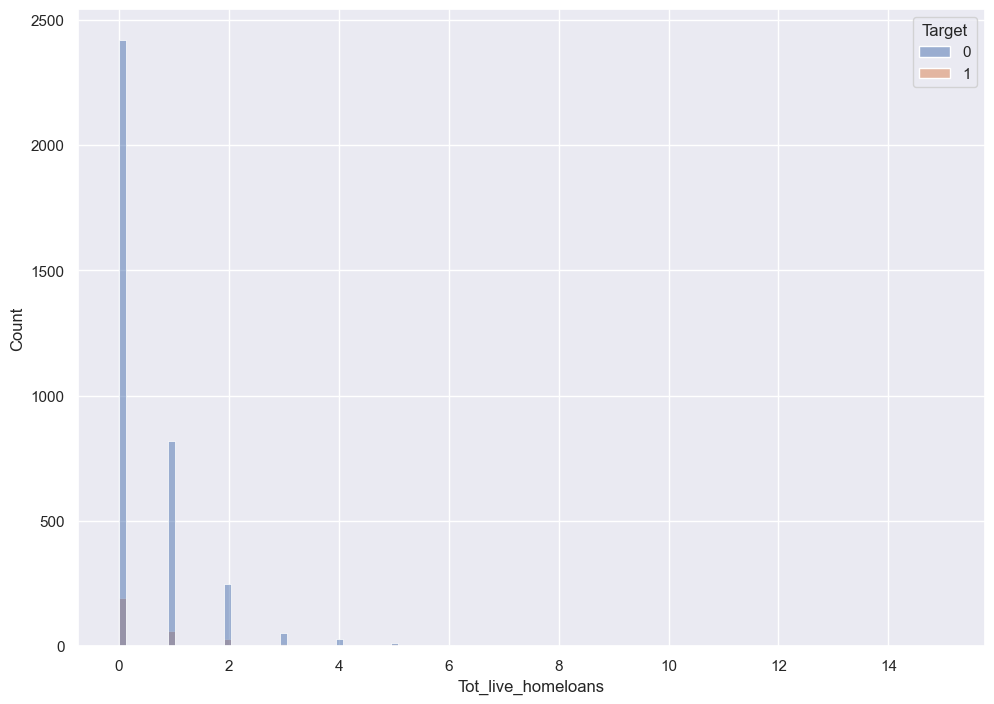

In [661]:
sns.histplot(x='Tot_live_homeloans',hue='Target',data=df)

<Axes: xlabel='Avg_days_in_debt', ylabel='Count'>

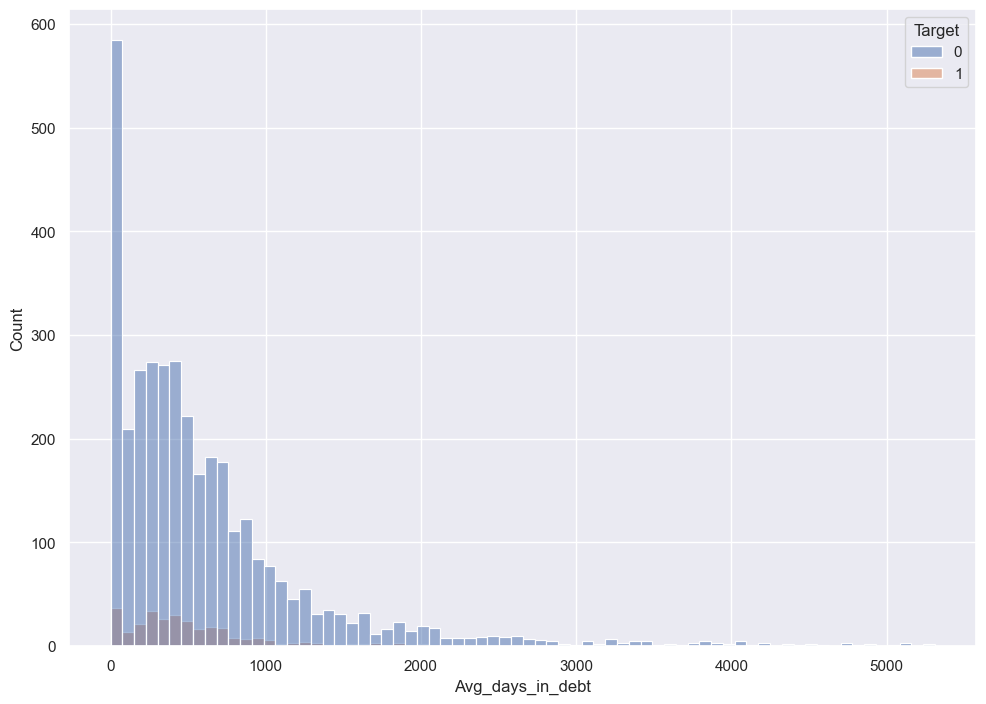

In [662]:
sns.histplot(x='Avg_days_in_debt',hue='Target',data=df)

<Axes: xlabel='SEX', ylabel='count'>

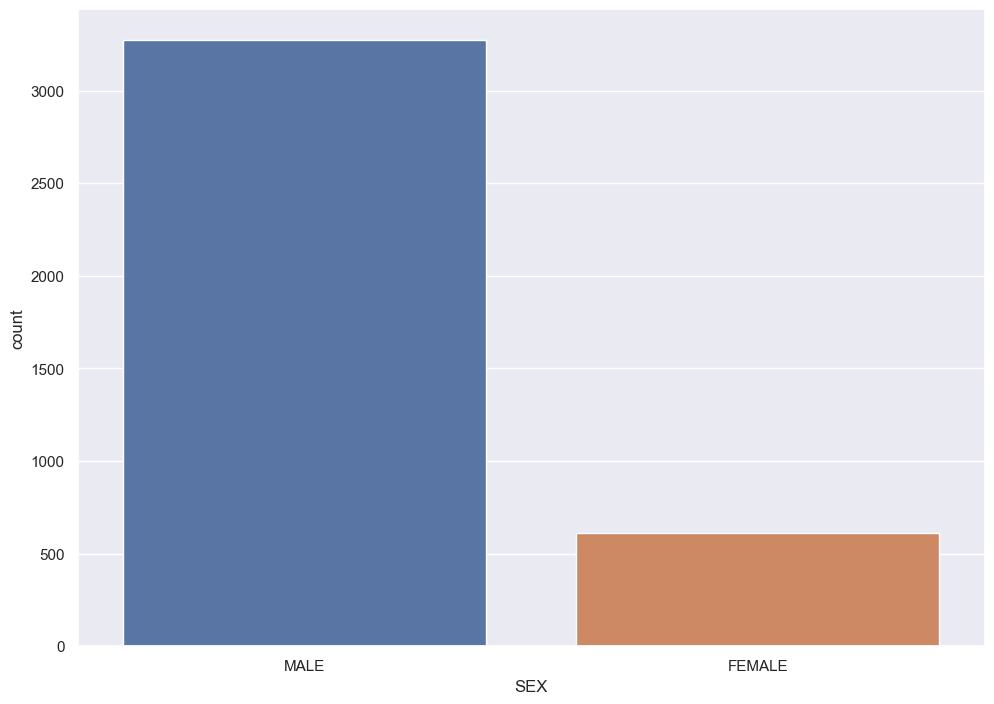

In [663]:
sns.countplot(x='SEX',data=df)

<Axes: xlabel='Customer_type', ylabel='Debt_ratio'>

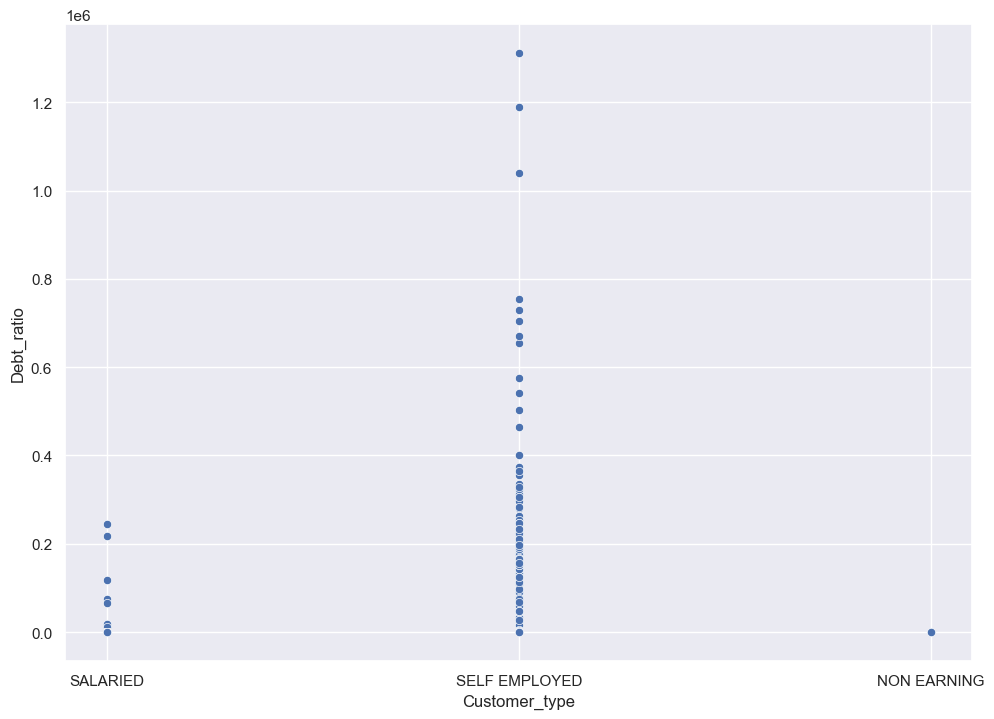

In [666]:
sns.scatterplot(x='Customer_type',y='Debt_ratio',data=df)

<Axes: xlabel='Marital_Status', ylabel='count'>

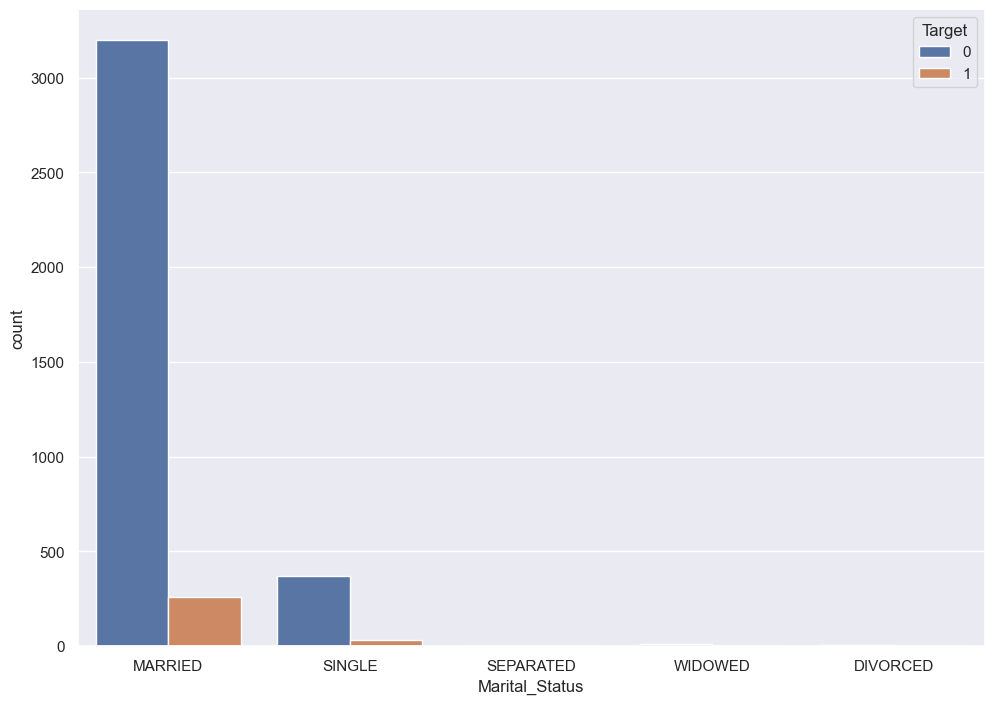

In [671]:
sns.countplot(x='Marital_Status',hue='Target',data=df)

<Axes: xlabel='Age', ylabel='Net_income'>

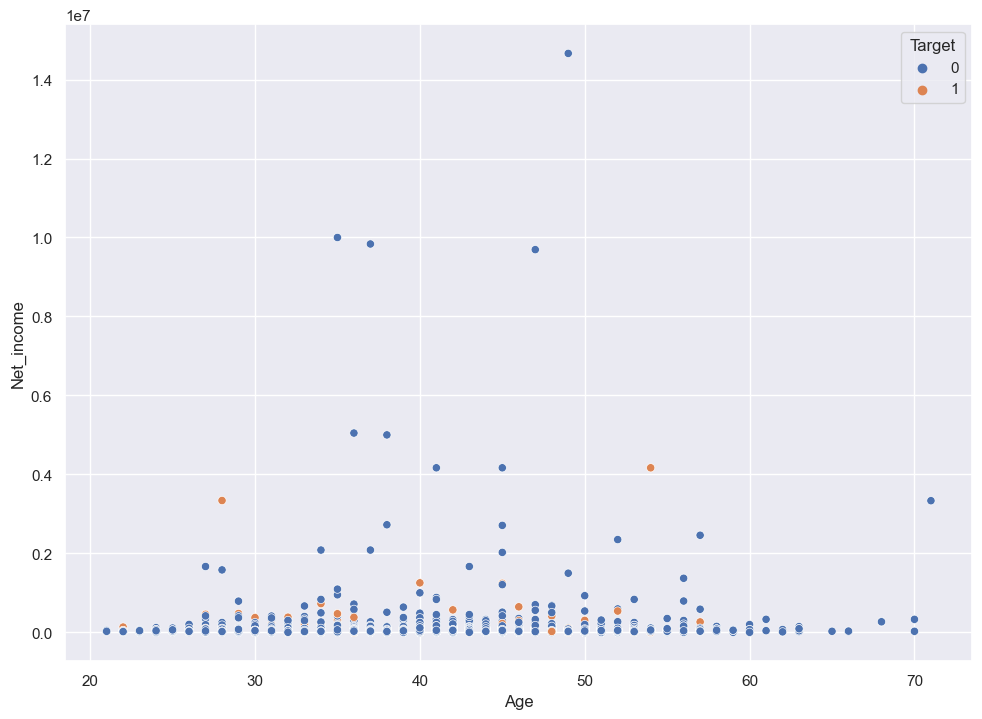

In [672]:
sns.scatterplot(x='Age',y='Net_income',hue='Target',data=df)

-----

<Axes: xlabel='Customer_type', ylabel='count'>

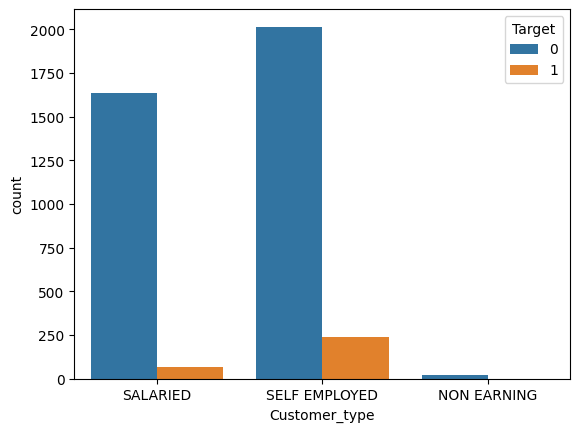

In [627]:
sns.countplot(x='Customer_type',hue='Target',data=df)

-----

In [14]:
dt = df.dtypes.to_frame()

In [15]:
non_obj = dt.loc[dt[0] != 'object',:].index.tolist()

In [16]:
non_obj.remove('ID')
non_obj.remove('Target')

In [17]:
for i in non_obj:
    for ii in non_obj:
        if ii != i:
            df.loc[:,'{}/{}'.format(i,ii)] = df[i]/df[ii]
        else:
            continue

In [18]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [19]:
df.fillna(0,inplace=True)

In [23]:
df.isnull().sum().sort_values().head(3)

ID                           0
Tot_accounts/Age             0
Tot_accounts/Gross_income    0
dtype: int64

In [24]:
df.shape

(3885, 791)

In [25]:
dt = df.dtypes.to_frame()

In [26]:
obj = dt.loc[dt[0] == 'object',:].index.tolist()

In [27]:
new_df = pd.get_dummies(df,columns=obj)

In [28]:
x = new_df.drop(columns=['ID','Target'])
y = new_df['Target']

In [29]:
model_rf = RandomForestClassifier(criterion='gini',n_estimators=150,n_jobs=-1,max_features='auto')

In [30]:
model_rf.fit(x,y)

RandomForestClassifier(max_features='auto', n_estimators=150, n_jobs=-1)

In [31]:
rf_df = pd.DataFrame(model_rf.feature_importances_,index=model_rf.feature_names_in_)

In [196]:
rf_df.sort_values(by=0,ascending=False).head(50)

,0
#_enq_3mnths/Age,0.005
#_enq_12mnths/Age,0.004
Net_income/Bank_balance,0.004
days_hl_last_enq/days_last_enq,0.004
Tot_enq/Avg_days_in_debt,0.004
#_hle_enq_12mnths/Age,0.004
Bank_balance/Age,0.003
Age,0.003
Age/Bank_balance,0.003
#_enq_12mnths/Debt_ratio,0.003


In [206]:
features_rf = list(set(rf_df.sort_values(by=0,ascending=False).head(30).index))

In [207]:
features_rf

['Months_in_city/Tot_enq',
 'Bank_balance/Net_income',
 'Debt_ratio/Bank_balance',
 '#_enq_12mnths/#_hle_enq_3mnths',
 'days_last_enq/Bank_balance',
 'Bank_balance/Gross_income',
 'Gross_income/days_last_enq',
 'Tot_enq/Net_income',
 '#_hle_enq_12mnths/Age',
 'Months_in_city/Tot_accounts',
 '#_enq_12mnths/Debt_ratio',
 '#_enq_12mnths/Tot_accounts',
 'Age',
 'Tot_enq/Avg_days_in_debt',
 'Tot_enq/Gross_income',
 'Bank_balance/days_last_acc_open',
 'days_hl_last_enq/days_last_enq',
 'Bank_balance/Age',
 'Net_income/Bank_balance',
 'Gross_income/Bank_balance',
 '#_enq_12mnths',
 'Tot_unsecured_outstanding_amt/#_defaults_3mnths',
 'days_last_acc_open/Bank_balance',
 'Months_in_current_job/Bank_balance',
 '#_enq_3mnths/Age',
 'Gross_income/Tot_accounts',
 '#_enq_12mnths/Age',
 'Age/Bank_balance',
 '#_enq_12mnths/Bank_balance',
 'Tot_enq/Tot_accounts']

In [37]:
dt = df.dtypes.to_frame()

In [38]:
non_obj = dt.loc[dt[0] != 'object',:].index.tolist()

In [39]:
non_obj.remove('ID')
non_obj.remove('Target')

In [40]:
non_obj_iv = pd.DataFrame()
for i in non_obj:
    temp = df.loc[:,[i,'Target']]
    temp['qcut'] = pd.qcut(temp[i],10,duplicates='drop')
    res = pd.crosstab(temp['qcut'],temp['Target'],normalize='columns').assign(woe=lambda x:np.log(x[0]/x[1])).assign(iv=lambda x:np.sum(x['woe']*(x[0]-x[1])))
    res['name'] = i
    non_obj_iv = pd.concat([non_obj_iv,res])

In [41]:
obj = dt.loc[dt[0] == 'object'][0].index.tolist()

In [42]:
obj_iv = pd.DataFrame()
for i in obj:
    res = pd.crosstab(df[i],df['Target'],normalize='columns').assign(woe=lambda x:np.log(x[0]/x[1])).assign(iv=lambda x:np.sum(x['woe']*(x[0]-x[1])))
    res['name'] = i
    obj_iv = pd.concat([obj_iv,res])

In [43]:
iv = pd.concat([non_obj_iv,obj_iv])

In [44]:
iv.head()

Target,0,1,woe,iv,name
"(20.999, 28.0]",0.118,0.115,0.022,0.057,Age
"(28.0, 31.0]",0.114,0.092,0.216,0.057,Age
"(31.0, 33.0]",0.093,0.092,0.013,0.057,Age
"(33.0, 35.0]",0.080,0.129,-0.474,0.057,Age
"(35.0, 38.0]",0.131,0.095,0.326,0.057,Age


In [47]:
iv_df = iv.groupby('name')[['iv']].sum()

In [124]:
iv_df.sort_values(by='iv',ascending=False).head()

Target,iv
name,
#_enq_12mnths/Age,2.834
Tot_enq/Age,2.269
Tot_enq,2.261
Net_income/Age,2.215
#_enq_12mnths,2.190


In [199]:
iv_df_co = iv_df[iv_df['iv'] >= 0.8].sort_values(by='iv',ascending=False)

In [200]:
features_iv = list(set(iv_df_co.index))

In [65]:
model_vc = VarClusHi(x,maxeigval2=1,maxclus=20)

In [ ]:
model_vc.varclus()

In [ ]:
vc_rs_df = model_vc.rsquare

In [175]:
vc_in_df = model_vc.info

In [179]:
vc_in_df.head()

,Cluster,N_Vars,Eigval1,Eigval2,VarProp
0,0,6,3.666,0.912,0.611
1,1,6,3.604,0.999,0.601
2,2,11,2.162,1.008,0.197
3,3,9,2.211,1.006,0.246
4,4,4,3.055,0.523,0.764


In [81]:
vc_df.head()

,Cluster,Variable,RS_Own,RS_NC,RS_Ratio
0,0,Tot_enq,0.630,0.422,0.639
1,0,Tot_accounts,0.679,0.148,0.377
2,0,Tot_unsecured_loans,0.748,0.119,0.286
3,0,Tot_live_loans,0.756,0.255,0.327
4,0,Tot_live_unsecuredloans,0.703,0.141,0.346


In [190]:
features_vc = []
for i in range(30):
    features_vc.append(vc_rs_df[vc_rs_df['Cluster'] == i][['Variable','RS_Ratio']].nsmallest(1,'RS_Ratio')['Variable'].values[0])

In [208]:
fin_features = features_rf + features_iv + features_vc

In [209]:
dict_ = Counter(fin_features)

In [210]:
len(dict_)

154

In [212]:
fin_features = [i for i,ii in dict_.items() if ii >= 2]

In [215]:
fin_features.append('Customer_type')
fin_features.append('Bank_balance')
fin_features.append('Target')

In [216]:
fin_features

['Bank_balance/Net_income',
 'Debt_ratio/Bank_balance',
 '#_enq_12mnths/#_hle_enq_3mnths',
 'Bank_balance/Gross_income',
 'Gross_income/days_last_enq',
 '#_enq_12mnths/Debt_ratio',
 '#_enq_12mnths/Tot_accounts',
 'Tot_enq/Avg_days_in_debt',
 'Net_income/Bank_balance',
 'Gross_income/Bank_balance',
 '#_enq_12mnths',
 '#_enq_3mnths/Age',
 '#_enq_12mnths/Age',
 '#_enq_12mnths/Bank_balance',
 'Tot_enq/Tot_accounts',
 'Debt_ratio',
 'Net_income',
 '#_enq_3mnths',
 'Customer_type',
 'Bank_balance']

In [381]:
fin_df = df[fin_features]

In [382]:
fin_df.head()

,Bank_balance/Net_income,Debt_ratio/Bank_balance,#_enq_12mnths/#_hle_enq_3mnths,Bank_balance/Gross_income,Gross_income/days_last_enq,#_enq_12mnths/Debt_ratio,#_enq_12mnths/Tot_accounts,Tot_enq/Avg_days_in_debt,Net_income/Bank_balance,Gross_income/Bank_balance,#_enq_12mnths,#_enq_3mnths/Age,#_enq_12mnths/Age,#_enq_12mnths/Bank_balance,Tot_enq/Tot_accounts,Debt_ratio,Net_income,#_enq_3mnths,Customer_type,Bank_balance,Target
0,0.605,0.000,0.000,0.533,218.799,5.263,0.111,0.003,1.653,1.875,1,0.000,0.025,0.000,1.556,0.190,62491.000,0,SALARIED,37806.000,0
1,0.289,0.000,0.000,0.289,87.041,0.000,0.000,0.002,3.459,3.459,0,0.000,0.000,0.000,1.375,0.420,53617.000,0,SALARIED,15499.000,0
2,0.327,0.000,0.000,0.752,29.070,0.000,0.000,0.001,3.054,1.330,0,0.000,0.000,0.000,0.750,0.340,45912.000,0,SALARIED,15034.000,0
3,0.353,0.000,1.500,0.684,769.231,37.500,3.000,0.001,2.832,1.463,3,0.041,0.061,0.000,3.000,0.080,77440.000,2,SALARIED,27349.000,0
4,0.781,0.000,0.000,0.781,1106.848,2.083,0.500,0.000,1.281,1.281,1,0.022,0.022,0.000,1.000,0.480,36526.000,1,SELF EMPLOYED,28520.000,0


In [383]:
vif_cols = [i for i in fin_features if i not in ['Customer_type','Target']]

In [384]:
vif_data = fin_df[vif_cols]

In [385]:
vif_df = pd.DataFrame([variance_inflation_factor(vif_data.values,i) for i in range(len(vif_data.columns))],index=vif_data.columns)

In [386]:
vif_df.sort_values(by=0,ascending=False).head(10)

,0
Bank_balance/Net_income,419.097
Bank_balance/Gross_income,416.370
#_enq_12mnths,97.809
#_enq_3mnths,95.285
#_enq_3mnths/Age,94.108
#_enq_12mnths/Age,92.542
Net_income/Bank_balance,35.884
Gross_income/Bank_balance,35.614
Tot_enq/Tot_accounts,4.440
#_enq_12mnths/Tot_accounts,4.318


In [387]:
vif_cols.remove('Bank_balance/Net_income')
vif_cols.remove('Bank_balance/Gross_income')
vif_cols.remove('#_enq_12mnths')
vif_cols.remove('Net_income/Bank_balance')
vif_cols.remove('#_enq_3mnths/Age')

In [388]:
vif_data = fin_df[vif_cols]

In [389]:
vif_df = pd.DataFrame([variance_inflation_factor(vif_data.values,i) for i in range(len(vif_data.columns))],index=vif_data.columns)

In [390]:
vif_df.sort_values(by=0,ascending=False).head()

,0
Tot_enq/Tot_accounts,4.398
#_enq_12mnths/Age,4.279
#_enq_12mnths/Tot_accounts,4.265
#_enq_3mnths,3.704
#_enq_12mnths/#_hle_enq_3mnths,2.102


In [391]:
len(vif_cols)

14

In [392]:
vif_cols.append('Customer_type')
vif_cols.append('Target')

In [393]:
fin_df = fin_df[vif_cols]

In [394]:
fin_df.drop_duplicates(keep=False,inplace=True)

In [395]:
x = fin_df.drop(columns=['Target'])
y = fin_df['Target']

In [396]:
x = pd.get_dummies(x)

In [397]:
x.head()

,Debt_ratio/Bank_balance,#_enq_12mnths/#_hle_enq_3mnths,Gross_income/days_last_enq,#_enq_12mnths/Debt_ratio,#_enq_12mnths/Tot_accounts,Tot_enq/Avg_days_in_debt,Gross_income/Bank_balance,#_enq_12mnths/Age,#_enq_12mnths/Bank_balance,Tot_enq/Tot_accounts,Debt_ratio,Net_income,#_enq_3mnths,Bank_balance,Customer_type_NON EARNING,Customer_type_SALARIED,Customer_type_SELF EMPLOYED
0,0.000,0.000,218.799,5.263,0.111,0.003,1.875,0.025,0.000,1.556,0.190,62491.000,0,37806.000,0,1,0
1,0.000,0.000,87.041,0.000,0.000,0.002,3.459,0.000,0.000,1.375,0.420,53617.000,0,15499.000,0,1,0
2,0.000,0.000,29.070,0.000,0.000,0.001,1.330,0.000,0.000,0.750,0.340,45912.000,0,15034.000,0,1,0
3,0.000,1.500,769.231,37.500,3.000,0.001,1.463,0.061,0.000,3.000,0.080,77440.000,2,27349.000,0,1,0
4,0.000,0.000,1106.848,2.083,0.500,0.000,1.281,0.022,0.000,1.000,0.480,36526.000,1,28520.000,0,0,1


In [398]:
x.shape

(3539, 17)

In [399]:
x.isnull().sum()

Debt_ratio/Bank_balance           0
#_enq_12mnths/#_hle_enq_3mnths    0
Gross_income/days_last_enq        0
#_enq_12mnths/Debt_ratio          0
#_enq_12mnths/Tot_accounts        0
Tot_enq/Avg_days_in_debt          0
Gross_income/Bank_balance         0
#_enq_12mnths/Age                 0
#_enq_12mnths/Bank_balance        0
Tot_enq/Tot_accounts              0
Debt_ratio                        0
Net_income                        0
#_enq_3mnths                      0
Bank_balance                      0
Customer_type_NON EARNING         0
Customer_type_SALARIED            0
Customer_type_SELF EMPLOYED       0
dtype: int64

----

In [400]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=37)

In [416]:
dt = x_train.dtypes.to_frame()

In [417]:
non_obj_dev = dt.loc[dt[0] != 'object',:].index.tolist()

In [425]:
non_obj_iv_dev = pd.DataFrame()
for i in non_obj_dev:
    temp = pd.concat([x_train.loc[:,[i]],y_train],axis=1)
    temp['qcut'] = pd.qcut(temp[i],10,duplicates='drop')
    res = pd.crosstab(temp['qcut'],temp['Target'],normalize='columns').assign(woe=lambda x:np.log(x[0]/x[1])).assign(iv=lambda x:np.sum(x['woe']*(x[0]-x[1])))
    res['name'] = i
    non_obj_iv_dev = pd.concat([non_obj_iv_dev,res])

In [426]:
obj_dev = dt.loc[dt[0] == 'object'][0].index.tolist()

In [427]:
obj_iv_dev = pd.DataFrame()
for i in obj_dev:
    res = pd.crosstab(x_train.loc[:,[i]],y_train,normalize='columns').assign(woe=lambda x:np.log(x[0]/x[1])).assign(iv=lambda x:np.sum(x['woe']*(x[0]-x[1])))
    res['name'] = i
    obj_iv_dev = pd.concat([obj_iv_dev,res])

In [428]:
iv_dev = pd.concat([non_obj_iv_dev,obj_iv_dev])

In [430]:
iv_dev.head()

Target,0,1,woe,iv,name
qcut,,,,,
"(-0.00100228, 1.2e-06]",0.101,0.091,0.104,0.182,Debt_ratio/Bank_balance
"(1.2e-06, 2.97e-06]",0.098,0.120,-0.206,0.182,Debt_ratio/Bank_balance
"(2.97e-06, 5.7e-06]",0.101,0.082,0.215,0.182,Debt_ratio/Bank_balance
"(5.7e-06, 8.88e-06]",0.104,0.053,0.681,0.182,Debt_ratio/Bank_balance
"(8.88e-06, 1.26e-05]",0.104,0.058,0.589,0.182,Debt_ratio/Bank_balance


In [432]:
iv_dev.rename(columns={0:'%good',1:'%bad'},inplace=True)

In [439]:
iv_dev.sort_values(by='iv',ascending=False).head()

Target,%good,%bad,woe,iv,name
qcut,,,,,
"(4.0, 24.0]",0.058616,0.197115,-1.212779,0.236638,#_enq_3mnths
"(2.0, 4.0]",0.122080,0.173077,-0.349058,0.236638,#_enq_3mnths
"(1.0, 2.0]",0.162186,0.115385,0.340473,0.236638,#_enq_3mnths
"(-0.001, 1.0]",0.657118,0.514423,0.244817,0.236638,#_enq_3mnths
"(0.0292, 0.0455]",0.103129,0.072115,0.357715,0.230420,#_enq_12mnths/Age


In [440]:
iv_dev.to_csv('Dev_IV.csv',index_label='qcut')

In [441]:
dt = x_test.dtypes.to_frame()

In [442]:
non_obj_oos = dt.loc[dt[0] != 'object',:].index.tolist()

In [443]:
non_obj_iv_oos = pd.DataFrame()
for i in non_obj_oos:
    temp = pd.concat([x_test.loc[:,[i]],y_test],axis=1)
    temp['qcut'] = pd.qcut(temp[i],10,duplicates='drop')
    res = pd.crosstab(temp['qcut'],temp['Target'],normalize='columns').assign(woe=lambda x:np.log(x[0]/x[1])).assign(iv=lambda x:np.sum(x['woe']*(x[0]-x[1])))
    res['name'] = i
    non_obj_iv_oos = pd.concat([non_obj_iv_oos,res])

In [444]:
obj_dev_oos = dt.loc[dt[0] == 'object'][0].index.tolist()

In [445]:
obj_iv_oos = pd.DataFrame()
for i in obj_dev_oos:
    res = pd.crosstab(x_test.loc[:,[i]],y_test,normalize='columns').assign(woe=lambda x:np.log(x[0]/x[1])).assign(iv=lambda x:np.sum(x['woe']*(x[0]-x[1])))
    res['name'] = i
    obj_iv_oos = pd.concat([obj_iv_oos,res])

In [446]:
iv_oos = pd.concat([non_obj_iv_oos,obj_iv_oos])

In [447]:
iv_oos.head()

Target,0,1,woe,iv,name
qcut,,,,,
"(-3.9619999999999997, 9.37e-07]",0.092574,0.202532,-0.782890,0.340025,Debt_ratio/Bank_balance
"(9.37e-07, 2.58e-06]",0.099695,0.101266,-0.015635,0.340025,Debt_ratio/Bank_balance
"(2.58e-06, 5.4e-06]",0.102747,0.063291,0.484521,0.340025,Debt_ratio/Bank_balance
"(5.4e-06, 8.29e-06]",0.097660,0.126582,-0.259398,0.340025,Debt_ratio/Bank_balance
"(8.29e-06, 1.16e-05]",0.100712,0.088608,0.128048,0.340025,Debt_ratio/Bank_balance


In [449]:
iv_oos.rename(columns={0:'%good',1:'%bad'},inplace=True)

In [450]:
iv_oos.sort_values(by='iv',ascending=False).head()

Target,%good,%bad,woe,iv,name
qcut,,,,,
"(0.506, 1.0]",0.203459,0.139241,0.379261,inf,Tot_enq/Tot_accounts
"(4.94e-05, 8.48e-05]",0.104781,0.088608,0.167658,inf,#_enq_12mnths/Bank_balance
"(0.000133, 0.000236]",0.097660,0.126582,-0.259398,inf,#_enq_12mnths/Bank_balance
"(0.000236, 0.000473]",0.095626,0.151899,-0.462773,inf,#_enq_12mnths/Bank_balance
"(0.000473, 0.0625]",0.096643,0.151899,-0.452191,inf,#_enq_12mnths/Bank_balance


In [451]:
iv_oos.drop(iv_oos[iv_oos['iv'].isin([np.inf,-np.inf])].index,inplace=True)

In [452]:
iv_oos.sort_values(by='iv',ascending=False).head()

Target,%good,%bad,woe,iv,name
qcut,,,,,
"(0.139, 0.219]",0.098678,0.113924,-0.143675,0.628063,#_enq_12mnths/Age
"(-0.001, 0.0176]",0.204476,0.151899,0.297237,0.628063,#_enq_12mnths/Age
"(0.0176, 0.028]",0.102747,0.063291,0.484521,0.628063,#_enq_12mnths/Age
"(0.028, 0.0417]",0.104781,0.101266,0.034126,0.628063,#_enq_12mnths/Age
"(0.0417, 0.0606]",0.104781,0.050633,0.727273,0.628063,#_enq_12mnths/Age


In [453]:
iv_oos.to_csv('OOS_IV.csv',index_label='qcut')

----

<Axes: ylabel='Target'>

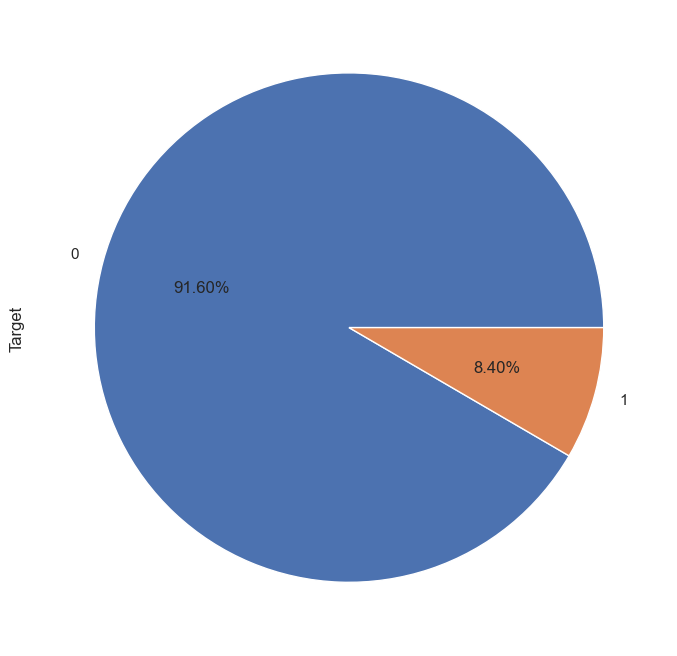

In [680]:
y_train.value_counts().plot.pie(autopct='%1.2f%%')

In [496]:
x_train_sm.columns

Index(['Debt_ratio/Bank_balance', '#_enq_12mnths/#_hle_enq_3mnths',
       'Gross_income/days_last_enq', '#_enq_12mnths/Debt_ratio',
       '#_enq_12mnths/Tot_accounts', 'Tot_enq/Avg_days_in_debt',
       'Gross_income/Bank_balance', '#_enq_12mnths/Age',
       '#_enq_12mnths/Bank_balance', 'Tot_enq/Tot_accounts', 'Debt_ratio',
       'Net_income', '#_enq_3mnths', 'Bank_balance',
       'Customer_type_NON EARNING', 'Customer_type_SALARIED',
       'Customer_type_SELF EMPLOYED'],
      dtype='object')

In [544]:
x_train_sm, y_train_sm = sm.fit_resample(x_train,y_train)

In [681]:
model_log = LogisticRegression(C=1.0,penalty='l1',solver='liblinear')

In [682]:
model_log.fit(x_train_sm,y_train_sm)

LogisticRegression(penalty='l1', solver='liblinear')

In [683]:
pred_dev = model_log.predict_proba(x_train_sm)[:,1]

In [684]:
roc_auc_score(y_train_sm,pred_dev)

0.8504677508045766

In [685]:
pred_oos = model_log.predict_proba(x_test)[:,1]

In [686]:
roc_auc_score(y_test,pred_oos)

0.6800545990702705

joblib.dump(model_log,'logistic_regression_1')

----

In [687]:
pred_proba_train = pd.DataFrame({'default':y_train_sm,'prob_num':model_log.predict_proba(x_train_sm)[:,1]})
pred_proba_test = pd.DataFrame({'default':y_test,'prob_num':model_log.predict_proba(x_test)[:,1]})

In [688]:
pred_proba_train.head(3)

,default,prob_num
0,0,0.156778
1,0,0.126068
2,0,0.589485


In [689]:
pred_proba_test.tail(3)

,default,prob_num
2452,0,0.110213
3242,0,0.095698
2455,0,0.149827


In [690]:
pred_proba_train['Target'] = pd.qcut(pred_proba_train['prob_num'],10, duplicates = 'drop')

In [691]:
pred_proba_test['Target'] = pd.qcut(pred_proba_test['prob_num'],10, duplicates = 'drop')

In [692]:
pred_proba_train['non_default'] = 1 - pred_proba_train['default']

In [693]:
pred_proba_test['non_default'] = 1 - pred_proba_test['default']

In [694]:
fin_pred_proba_train = pd.pivot_table(index='Target',values=['default','non_default'],aggfunc={'default':np.sum,'non_default':np.sum},data=pred_proba_train)

In [695]:
fin_pred_proba_test = pd.pivot_table(index='Target',values=['default','non_default'],aggfunc={'default':np.sum,'non_default':np.sum},data=pred_proba_test)

In [696]:
fin_pred_proba_train.to_csv('Lift Table Dev data.csv')

In [697]:
fin_pred_proba_test.to_csv('Lift Table OOS data.csv')